# Having fun with `wav2vec`


**Warning** it is strongly advised to do this lab in google colab (in spite of all the “ethical” problems resulting from using this service).

`wav2vec` is a neural network using a `transformer` architecture to model speech and `xlsr-53` is a pre-trained multilingual model of `wav2vec`: using this model, it is possible to build a vector representation of an audio segment in any language that can be used for any speech processing task. In this lab, we will focus on the *automatic transcription* task whose objective is to convert an audio input into text and we will use these representation to evaluate the similarity between languages.

We will start by installing the different libraries that we will use:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Lab6'

In [ ]:
!pip install ffmpeg-python
!pip install transformers
!pip install evaluate
!pip install jiwer
!apt-get install ffmpeg
!apt-get install libavutil-dev

**1. Why can't we use $pip$ to install $ffmpeg$ ?**

Because *ffmpeg* is a systematic package, it is not a package written in Python and therefore cannot be installed with `pip`, which is a package manager for Python. Packages installed with the `apt-get` command line are systemized packages and are fully installed within the system, while python packages installed with the `pip` command line can be installed only within the current project.


## Recording wav files using the computer microphone

**Remarque** : If you don't have access to a computer with a microphone, you can skip to the next part (and come back to this one later)

The next cell defines a function `get_audio()` which allows you to record an audio file from the computer's microphone. This function can only be run in a browser (i.e. using google colab). It returns two variables: 

- the audio data
- the samping rate

This data can be stored into a wav file using the following instructions:

```python
import scipy

audio, sr = get_audio()
scipy.io.wavfile.write('my_file.wav', sr, audio)
```

Do not forget that this file is stored in a virtual machine and will be deleted as soon as this machine is shutdown. You can download it to your computer with:
```
from google.colab import files
files.download("/content/mon_fichier.wav")
```

In [ ]:
"""
code of Noé Tits - Numediart (UMONS) - noetits.com
https://colab.research.google.com/drive/1Z6VIRZ_sX314hyev3Gm5gBqvm1wQVo-a#scrollTo=uNzFbnQqz0gu
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

**2. Create an audio corpus consisting of about ten sentences (300 words) in the language of your choice (you should check that there exists a transcription model for the language you choose — see below) and their transcription. Each sentence should be stored in a different `wav` file. Transcription is a time-consuming task that is not very interesting (rule of thumb: it takes 10 minutes to transcribe 1 minute of audio). It is easier to read existing sentences than to transcribe new data from scratch. Make sure you choose sentences of different registers (e.g. sentences with technical terms, proper nouns or everyday language).**

In [ ]:
import scipy
from google.colab import files

for i in range(10):
    audio, sr = get_audio()
    name = f"audio_{i+1}.wav"
    scipy.io.wavfile.write(name, sr, audio)
    files.download(name)

## Using a pre-trained model

The `HuggingFace`🤗 library provides a simple way to use pretrained models. It defines an API (set of functions) that allow you to:

- automatically download a model from its identifier (a string) and easily retrieve the models corresponding to a language/task thanks to the “[model hub](https://huggingface.co/models)”. The downloaded models are stored in a [cache](https://en.wikipedia.org/wiki/Cache_(computing)).
- provide high-level methods for manipulating and using these models

We will first use a pre-trained model to automatically recognize French recordings (`jonatasgrosman/wav2vec2-large-xlsr-53-french`). This model has been trained by fine-tuning the XLS-R model on a French corpus.

You will find pre-trained models for all languages (almost) on the model hub.

**3. Why are downloaded models cached ?**

Because when a pre-trained model is to be used, the model is downloaded from a remote server and stored on the user's device, caching the model allows subsequent access to the model to be faster because it does not need to be downloaded again. Caching the model also ensures that the model can be used even if the remote server is temporarily unavailable. In addition, sometimes the pre-trained model is quite large and each download may result in slow code execution, reducing the time and resources required to access the model by caching the pre-trained model can improve the user experience.


**4. Are there other speech recognition models for French available on HuggingFace 🤗 model hub.**

Yes, there are other speech recognition models for French like $openai/whisper-medium$. We can find more in the link below：
https://huggingface.co/models?language=fr&pipeline_tag=automatic-speech-recognition&sort=downloads

HuggingFace 🤗 uses `DataFrame` to store and manipulate annotated corpora. A `DataFrame` is a data structure defined in the `pandas` library which is today the main data analysis library in Python to represent tabular data (caricaturally, a sheet in a spreadsheet): each row represents an *example* which is described by a set of *variables* or *features* corresponding to the columns.

The following code allows to initialize the `DataFrame` corresponding to the corpus we are going to use: 

In [ ]:
import pandas as pd

# corpus is a list of dictionaries 
# there is one dictionary for each example
# the column names are the keys
corpus = [
    {"filename": "/content/sentence_01.wav",
     "transcription": "Bonjour les amis"},
    {"filename": "/content/sentence_02.wav",
     "transcription": "Comment allez-vous"}
]

**5. Build a $DataFrame$ to store the corpus collected in the previous question.**

In [ ]:
corpus = pd.DataFrame(corpus)
corpus

,filename,transcription
0,/content/sentence_01.wav,Bonjour les amis
1,/content/sentence_02.wav,Comment allez-vous


**6. Build a $DataFrame$ to store the French corpus avalaible in the Moodle: the corpus is made of several audio files and a json file that maps the name of an audio file to its transcription.**

In [ ]:
import json
# read audio_corpus from Moodle
with open(root_path + '/audio_corpus/transcriptions.json', 'r') as f:
    transcriptions = json.load(f)
audio_corpus = pd.DataFrame(transcriptions, columns=['filename','transcriptions'])
audio_corpus['filename'] = root_path + '/audio_corpus/' + audio_corpus['filename']

In [ ]:
audio_corpus.head(5)

,filename,transcriptions
0,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Un vrai travail intéressant va, enfin, être me..."
1,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Une réforme profonde est nécessaire.
2,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Pas si nombreuses que ça
3,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Un comité interministériel du handicap s’est t...
4,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"La parole est à Monsieur Alain Ramadier, pour ..."


In [ ]:
# read new audios
with open(root_path + '/audios_new/transcriptions.json', 'r') as f:
    transcriptions = json.load(f)
audios_new = pd.DataFrame(transcriptions, columns=['filename','transcriptions'])
audios_new['filename'] = root_path + '/audios_new/' + audios_new['filename']

In [ ]:
audios_new.head(5)

,filename,transcriptions
0,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Chapter sixteen, I might have told you of the ..."
1,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Marguerite to be unable to live apart from me,..."
2,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,I wished above all not to leave myself time to...
3,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Assumed all at once an appearance of noise and...
4,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Nothing is so expensive as their caprices flow...


### Loading audio files

The code in the next cell adds a column to the `DataFrame` we have juste created (`corpus`). To do this, the `apply` method will call the `load4xslr` function for each value in the `filename` column. This function, in addition to “loading” the file, will make sure that it is in a format suitable for the model (in particular that it is sampled at $16,000$ Hz).

For each row, the `audio` column will contain a row vector corresponding the the audio data: the number of elements in this matrix will be proportional to the length of the audio file and the $i$-th value (a real number) will correspond to the value of the audio signal at the $i$-th time step.


In [ ]:
import torchaudio
import librosa

from pathlib import Path

import numpy as np


def load4xslr(audio_filepath: str, window_size: int=None, frame_offset: int=None) -> np.ndarray:
    """
    Load a wav file and ensure that it can be used in XSL-R/wav2vec

    To be used by XSL-R, wav files have to:
    - have a sampling rate of 16_000Hz
    - use only one channel (mono file)

    Parameters:
    - audio_filepath, str --> path to the file
    - window_size, int, frame_offset --> if not None, return `window_size` ms of audio data 
            centered around `frame_offset`; if both None, returns the full file.
    """
    speech_array, sampling_rate = librosa.load(Path(audio_filepath))
    speech = librosa.to_mono(speech_array)

    speech = librosa.resample(speech, orig_sr=sampling_rate, target_sr=16_000)

    if frame_offset is None and window_size is None:
        return speech

    if frame_offset is None:
        frame_offset = speech.shape[0] // 2

    assert speech.shape[0] / sampling_rate > window_size / 1_000,\
        f"File too short ({speech.shape[0] / sampling_rate:.2f}s) to extract a {window_size // 1000}s windows "

    window_size = int(16_000 * window_size // 2_000)

    return speech[frame_offset - window_size:frame_offset + window_size]

In [ ]:
import warnings

warnings.filterwarnings('ignore')
# transform audio_corpus to digital samples
corpus = audio_corpus
corpus["audio"] = corpus["filename"].apply(load4xslr)

In [ ]:
corpus.head(5)

,filename,transcriptions,audio
0,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Un vrai travail intéressant va, enfin, être me...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Une réforme profonde est nécessaire.,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Pas si nombreuses que ça,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Un comité interministériel du handicap s’est t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"La parole est à Monsieur Alain Ramadier, pour ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Here we can see that there are a lot of zeros in column "audio", in fact, from the plot wave below, we can see that an audio often begins with a silence. That's why we see all zeros here.

In [ ]:
# transform new audios to digital samples
corpus_new = audios_new
corpus_new["audio"] = corpus_new["filename"].apply(load4xslr)

In [ ]:
corpus_new.head(5)

,filename,transcriptions,audio
0,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Chapter sixteen, I might have told you of the ...","[0.0006042509, 0.00079266785, 0.0006878737, 0...."
1,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,"Marguerite to be unable to live apart from me,...","[-8.720141e-05, -0.00015254486, -0.00015483795..."
2,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,I wished above all not to leave myself time to...,"[-0.0002225046, -0.00025243868, -0.00018108803..."
3,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Assumed all at once an appearance of noise and...,"[-0.00020419578, -0.00042594227, -0.0005544026..."
4,/content/drive/MyDrive/Colab Notebooks/Lab6/au...,Nothing is so expensive as their caprices flow...,"[0.00023103744, 0.00033710588, 0.00018532941, ..."


The following code allows you to access to the signal corresponding to the record of the line `n` (the attribute `loc` of a `DataFrame` allows to access a value by specifying its line and column).

In [ ]:
n = 10
print(f"size of the matrice: {corpus.loc[n, 'audio'].shape}")
print(f"corresponding values: {corpus.loc[n, 'audio']}")

size of the matrice: (41857,)
corresponding values: [0. 0. 0. ... 0. 0. 0.]


The signal can also be visualized using the following function:

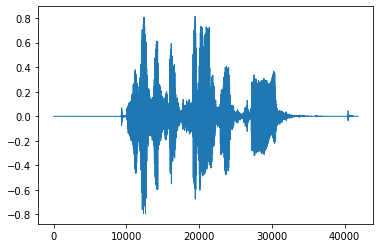

In [ ]:
import matplotlib.pyplot as plt

def plot_waveform(waveform, sample_rate):    
    figure, axes = plt.subplots(1, 1)
    axes.plot(range(waveform.shape[0]), waveform, linewidth=1)
    plt.show(block=False)

plot_waveform(corpus.loc[n, "audio"], 16_000)

**7. What will be the size of the matrix storing a 3 minute and 17 second audio signal ?**

In [ ]:
# 16,000 samples per second
16_000 * (3 * 60 + 17)

3152000

The size of the matrix is 3152000.

## Automatic transcription

The following cell will perform an automatic transcription of the corpus (stored in a new column called `automatic_transcription`) by:

1. downloading the pretrained modls (using the `from_pretrained` functions)
1. pre-processing the audio-data to ensure they are in the expected format (appel à `processor`)
1. transcribe the audio by “calling” the `model` to predict the probability that an audio frame is associated to a character and looking for the highest-scoring character. This probabilities are stored in a *tensor* (a 3 dimensions matrix).

In [ ]:
import torch

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# predicte corpus
model_id = "jonatasgrosman/wav2vec2-large-xlsr-53-french"

processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)

inputs = processor(list(corpus["audio"])[:10],
                   sampling_rate=16_000,
                   return_tensors="pt",
                   padding=True)

with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

predicted_ids = torch.argmax(logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

corpus["automatic_transcription"] = pd.Series(predicted_sentences)

In [ ]:
# predicte corpus_new
model_id = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

processor = Wav2Vec2Processor.from_pretrained(model_id)
model = Wav2Vec2ForCTC.from_pretrained(model_id)

inputs = processor(list(corpus_new["audio"])[:10],
                   sampling_rate=16_000,
                   return_tensors="pt",
                   padding=True)

with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

predicted_ids = torch.argmax(logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

corpus_new["automatic_transcription"] = pd.Series(predicted_sentences)

**8. What is the shape (dimensions) of logit. What does each dimension represent ?**

In [ ]:
logits.shape

torch.Size([10, 804, 33])

The shape of logit is a three-dimensional tensor with each dimension of size 10, 804 and 33. The first dimension 10 indicates the number of samples in the tensor, the second dimension 804 indicates the sequence length, or the number of feature vectors in each sample, and the third dimension 33 indicates the size of each feature vector or the number of features in each feature vector. Thus, the logit tensor has 10 samples, each sample has 804 feature vectors, and each feature vector has 33 features.

**9. Explain the instruction torch.argmax(logits, dim=-1).**

In [ ]:
predicted_ids.shape

torch.Size([10, 804])

`torch.argmax()` is a function in PyTorch that returns the index of the maximum value along a certain dimension in the tensor. In the command `torch.argmax(logits, dim=-1)`, the dim argument is set to -1, which means that the maximum value will be taken along the last dimension of logits.

**10. Evaluate qualitatively the quality of the automatic transcription for the two corpora considered (the one you collected and the one on the moodle).**

In [ ]:
corpus[['transcriptions', 'automatic_transcription']].head(10)

,transcriptions,automatic_transcription
0,"Un vrai travail intéressant va, enfin, être me...",un vrai travail intéressant va enfin être mené...
1,Une réforme profonde est nécessaire.,une réforme profonde est nécessaire teire
2,Pas si nombreuses que ça,pas si nombreuses que ça
3,Un comité interministériel du handicap s’est t...,un camité interministérial du handicup s'est t...
4,"La parole est à Monsieur Alain Ramadier, pour ...",la parole est à monsieur lalain ramadière pour...
5,C’est en tout cas jupitérien,c'est en tout cas jupiteria
6,Aux voix,au voix
7,"J’ai donc l’expérience des années passées, j’e...",jai donc lexpérience des années passées jen di...
8,Douze minutes trente,douze minutes trente
9,C’est une évidence.,cest une évidence


In [ ]:
corpus_new[['transcriptions', 'automatic_transcription']].head(10)

,transcriptions,automatic_transcription
0,"Chapter sixteen, I might have told you of the ...",chapter sixteeni might have told you of the be...
1,"Marguerite to be unable to live apart from me,...",marguerite to be unable to live apart from mei...
2,I wished above all not to leave myself time to...,i wished above all not to leave myself time to...
3,Assumed all at once an appearance of noise and...,assumed all at once an appearance of noise and...
4,Nothing is so expensive as their caprices flow...,nothing is so expensive as their caprices flow...
5,My father was and still is receveur general at...,my father was and still is receiver-general at...
6,I came to paris studied law was called to the ...,i came to paris studied law was called to the ...
7,My expenses were very moderate only I used up ...,my expenses were very moderate only i used up ...
8,For the rest not a penny of debt this then was...,for the rest not a penny of debtthis then was ...
9,Marguerite's nature was very capricious and li...,marguerite's nature was very capricious and li...


By comparing the quality of the automatic transcription, we can see that the transcription is relatively good and most of the words can be transcribed correctly, but there are still some shortcomings. For example, the case at the beginning of sentences and the punctuation marks appearing in the sentences cannot be recognized, resulting in incorrect transcription. In addition, there are some words in French that need to be connected by an apostrophe ', as in the above sentence, "s'est" is transcribed correctly, but "jai" is missing the apostrophe '. Also in the sentence numbered 6, "Aux voix" and "au voix" are both possible cases in practice.

**11. The quality of automatic transcriptions is generally evaluated using the Word Error Rate (WER). Describe intuitively how this metric is working.**

The Word Error Rate (WER) is a measure of the accuracy of an automatic speech recognition system. It measures the accuracy of automatic transcription by comparing the transcribed text with the reference text. It calculates the number of incorrect, replaced or deleted words in the transcribed text as a percentage of the total number of words in the reference text (number of incorrect words)/(total number of words); the lower the WER, the more accurate the transcription is.

The HuggingFace 🤗 library contains functions for almost all existing metrics, including one to calculate the WER:

```python
from evaluate import load
wer = load("wer")
wer_score = wer.compute(predictions=...,
                        references=...)
```

This function takes as parameters, two lists of sentences (or more precisely, two *iterable*s i.e. python structures that can be used in a `for` loop).

**12. Compute the WER on your two corpora ?**

In [ ]:
from evaluate import load

wer = load("wer")
# calculate WER with corpus
wer_score = wer.compute(predictions=corpus['automatic_transcription'][:10], references=corpus['transcriptions'][:10])
wer_score

0.4305555555555556

In [ ]:
# calculate WER with corpus_new
wer_score = wer.compute(predictions=corpus_new['automatic_transcription'][:10], references=corpus_new['transcriptions'][:10])
wer_score

0.16620498614958448

**13. Compute the WER between `Le chat, le chien et le lamantin` and `le chat le chien et le lamantin`. What can you conclude about the validity of the score you just calculated ?**

In [ ]:
# test 1
wer_score = wer.compute(predictions=['le chat le chien et le lamantin'], references=['Le chat, le chien et le lamantin'])
wer_score

0.2857142857142857

In [ ]:
# test 2
wer_score = wer.compute(predictions=['le chat le chien et le lamantin'], references=['Le chat , le chien et le lamantin'])
wer_score

0.25

The above calculation shows that the WER score still needs to be improved. We can conclude that the case of letters affects the WER, but in practice the orthography should not affect the WER score, because WER only considers the correctness at the word level and does not focus on the correct spelling. In addition, the "comma" also accounts for a "word", e.g., in test 2, by adding a "space" in front of the "comma", the WER changes.


It is possible to apply string methods (e.g. `upper`) to all elements of a column with: 

```python
df["nouvelle_colonne"] = df["col"].str.upper()
```

**14. Compute the WER after normalizing the references and the automatic transcription (to make them more “comparable”). What can you conclude ?**

In [ ]:
# to corpus
# convert all to uppercase
corpus["transcriptions_capital"] = corpus["transcriptions"].str.upper()
corpus["automatic_transcription_capital"] = corpus["automatic_transcription"].str.upper()
# remove commas and periods
corpus["transcriptions_deleted"] = corpus["transcriptions_capital"].str.replace(',', '').str.replace('.', '')
# print the first ten lines
corpus[["transcriptions_capital", "transcriptions_deleted", "automatic_transcription_capital"]][:10]

,transcriptions_capital,transcriptions_deleted,automatic_transcription_capital
0,"UN VRAI TRAVAIL INTÉRESSANT VA, ENFIN, ÊTRE ME...",UN VRAI TRAVAIL INTÉRESSANT VA ENFIN ÊTRE MENÉ...,UN VRAI TRAVAIL INTÉRESSANT VA ENFIN ÊTRE MENÉ...
1,UNE RÉFORME PROFONDE EST NÉCESSAIRE.,UNE RÉFORME PROFONDE EST NÉCESSAIRE,UNE RÉFORME PROFONDE EST NÉCESSAIRE TEIRE
2,PAS SI NOMBREUSES QUE ÇA,PAS SI NOMBREUSES QUE ÇA,PAS SI NOMBREUSES QUE ÇA
3,UN COMITÉ INTERMINISTÉRIEL DU HANDICAP S’EST T...,UN COMITÉ INTERMINISTÉRIEL DU HANDICAP S’EST T...,UN CAMITÉ INTERMINISTÉRIAL DU HANDICUP S'EST T...
4,"LA PAROLE EST À MONSIEUR ALAIN RAMADIER, POUR ...",LA PAROLE EST À MONSIEUR ALAIN RAMADIER POUR S...,LA PAROLE EST À MONSIEUR LALAIN RAMADIÈRE POUR...
5,C’EST EN TOUT CAS JUPITÉRIEN,C’EST EN TOUT CAS JUPITÉRIEN,C'EST EN TOUT CAS JUPITERIA
6,AUX VOIX,AUX VOIX,AU VOIX
7,"J’AI DONC L’EXPÉRIENCE DES ANNÉES PASSÉES, J’E...",J’AI DONC L’EXPÉRIENCE DES ANNÉES PASSÉES J’EN...,JAI DONC LEXPÉRIENCE DES ANNÉES PASSÉES JEN DI...
8,DOUZE MINUTES TRENTE,DOUZE MINUTES TRENTE,DOUZE MINUTES TRENTE
9,C’EST UNE ÉVIDENCE.,C’EST UNE ÉVIDENCE,CEST UNE ÉVIDENCE


In [ ]:
wer_score = wer.compute(predictions=corpus['automatic_transcription_capital'][:10], references=corpus['transcriptions_deleted'][:10])
wer_score

0.2222222222222222

In [ ]:
# to corpus_new
# convert all to uppercase
corpus_new["transcriptions_capital"] = corpus_new["transcriptions"].str.upper()
corpus_new["automatic_transcription_capital"] = corpus_new["automatic_transcription"].str.upper()
# remove commas and periods
corpus_new["transcriptions_deleted"] = corpus_new["transcriptions_capital"].str.replace(',', '').str.replace('.', '')
# print the first ten lines
corpus_new[["transcriptions_capital", "transcriptions_deleted", "automatic_transcription_capital"]][:10]

,transcriptions_capital,transcriptions_deleted,automatic_transcription_capital
0,"CHAPTER SIXTEEN, I MIGHT HAVE TOLD YOU OF THE ...",CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE B...,CHAPTER SIXTEENI MIGHT HAVE TOLD YOU OF THE BE...
1,"MARGUERITE TO BE UNABLE TO LIVE APART FROM ME,...",MARGUERITE TO BE UNABLE TO LIVE APART FROM ME ...,MARGUERITE TO BE UNABLE TO LIVE APART FROM MEI...
2,I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO...,I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO...,I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO...
3,ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND...,ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND...,ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND...
4,NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOW...,NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOW...,NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOW...
5,MY FATHER WAS AND STILL IS RECEVEUR GENERAL AT...,MY FATHER WAS AND STILL IS RECEVEUR GENERAL AT...,MY FATHER WAS AND STILL IS RECEIVER-GENERAL AT...
6,I CAME TO PARIS STUDIED LAW WAS CALLED TO THE ...,I CAME TO PARIS STUDIED LAW WAS CALLED TO THE ...,I CAME TO PARIS STUDIED LAW WAS CALLED TO THE ...
7,MY EXPENSES WERE VERY MODERATE ONLY I USED UP ...,MY EXPENSES WERE VERY MODERATE ONLY I USED UP ...,MY EXPENSES WERE VERY MODERATE ONLY I USED UP ...
8,FOR THE REST NOT A PENNY OF DEBT THIS THEN WAS...,FOR THE REST NOT A PENNY OF DEBT THIS THEN WAS...,FOR THE REST NOT A PENNY OF DEBTTHIS THEN WAS ...
9,MARGUERITE'S NATURE WAS VERY CAPRICIOUS AND LI...,MARGUERITE'S NATURE WAS VERY CAPRICIOUS AND LI...,MARGUERITE'S NATURE WAS VERY CAPRICIOUS AND LI...


In [ ]:
wer_score_new = wer.compute(predictions=corpus_new['automatic_transcription_capital'][:10], references=corpus_new['transcriptions_deleted'][:10])
wer_score_new

0.08033240997229917

We can observe an improvement in WER scores after "normalization". For example, we do not focus on the case of words, so we convert all corpus to uppercase, which reduces the WER. also, punctuation in speech can help us understand sentence pauses, but the model cannot predict them, which is where it can be improved. In addition, the pronunciation of "aux" and "au" is the same in French, which also shows the limitation of speech prediction.

## Language distance

We will now use the representations computed by `XSL-R` to measure the similarity between different languages.

You will find, on the moodle, an archive (`commonvoice_sample.tar`) containing audio recording in different European (or not)languages. The language of a file can be extracted from the filename.

**15. Write a function that takes as parameters a language, a window size and a number of segments n and returns a list of n segments of window_size seconds in a given language sampled randomly from all files.**

In [ ]:
import os
import random

In [ ]:
def load4xslr(audio_filepath: str, window_size: int=None, frame_offset: int=None) -> np.ndarray:
    """
    Load a wav file and ensure that it can be used in XSL-R/wav2vec

    To be used by XSL-R, wav files have to:
    - have a samping rate of 16_000Hz
    - use only one channel (mono file)

    Parameters:
    - audio_filepath, str --&gt; path to the file
    - window_size, int, frame_offset --> if not None, return `window_size` ms of audio data 
            centered around `frame_offset`; if both None, returns the full file.
    """
    speech_array, sampling_rate = librosa.load(Path(audio_filepath))
    speech = librosa.to_mono(speech_array)

    speech = librosa.resample(speech, orig_sr=sampling_rate, target_sr=16_000)

    if frame_offset is None and window_size is None:
        return speech

    result = np.zeros(16 * window_size)

    if frame_offset is None:
        frame_offset = speech.shape[0] // 2
    # result_offset = result.shape[0] // 2

    window_size = int(16_000 * window_size // 2_000)
    d = min(frame_offset, window_size)
    m1 = result.shape[0] // 2
    m2 = frame_offset
    # l1 = max(result_offset - window_size, 0)
    # r1 = min(result_offset + window_size, len(result))
    # l2 = max(frame_offset - window_size, 0)
    # r2 = min(frame_offset + window_size, len(speech))
    result[m1-d:m1+d] = speech[m2-d:m2+d]
    return result

In [ ]:
def list_samples(language, window_size, nb_segments):
    dir_path = root_path + '/commonvoice_sample'
    list_audios = [] # list to store audio_files
    for item in os.listdir(dir_path):
        # check if current file contains the given language
        if item.startswith('common_voice_' + language):
            list_audios.append(root_path + '/commonvoice_sample/' + item)
    # get segments randomly
    list_segments = random.sample(list_audios, nb_segments)
    result = []
    for item in list_segments:
        result.append(load4xslr(item, window_size))
    return result

In [ ]:
test = list_samples('en', 5000, 10)
test

[array([ 1.12818670e-04, -2.00865223e-04,  9.32109979e-05, ...,
        -2.25240568e-04,  1.31657161e-03,  3.22464883e-04]),
 array([ 0.00310873,  0.00154445, -0.00057344, ..., -0.00093501,
        -0.00095436, -0.00093148]),
 array([-0.00015116, -0.00028248, -0.00023482, ..., -0.00084061,
        -0.00146101,  0.00288341]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.40063394e-05, -2.58817022e-06, -1.62675540e-04]),
 array([-1.52720764e-04, -2.60677880e-05, -1.95259181e-05, ...,
         8.99787483e-05, -1.87905935e-05, -6.66837077e-05]),
 array([-0.00591219,  0.00888403,  0.02620041, ...,  0.01045166,
         0.00940508,  0.00855389]),
 array([-6.89222288e-05,  2.53340171e-04,  1.25978433e-04, ...,
        -2.19698595e-05, -2.09821592e-05, -1.20415680e-05]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.03836175,  0.03868292,  0.03962336, ..., -0.00020483,
        -0.00028489, -0.00037819]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00

**16. Write a function that takes as parameter a list of audio segments and uses XSL-R to compute a list containing a representation of each segment (using the function in the following cell).**

In [ ]:
from typing import Tuple

def load_xlsr53_model(device: str = "cpu") -> Tuple[Wav2Vec2ForCTC, Wav2Vec2Processor]:
    """
    Load the XLSR-53 Large model (i.e. processor and model).

    As the model is not fine-tuned, we need to manually build the processor
    """

    import tempfile
    import json
    from transformers import Wav2Vec2FeatureExtractor
    from transformers import Wav2Vec2CTCTokenizer

    ofile = tempfile.NamedTemporaryFile("wt")
    json.dump({"[UNK]": "0", "[PAD]": "1"}, ofile)
    ofile.flush()

    tokenizer = Wav2Vec2CTCTokenizer(ofile.name,
                                     unk_token="[UNK]",
                                     pad_token="[PAD]",
                                     word_delimiter_token="|")
    feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1,
                                                 sampling_rate=16_000,
                                                 padding_value=0.0,
                                                 do_normalize=True,
                                                 return_attention_mask=True)
    xlsr_processor = Wav2Vec2Processor(feature_extractor=feature_extractor,
                                       tokenizer=tokenizer)
    xlsr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53").to(device)

    return xlsr_model, xlsr_processor

def get_xlsr_representation(
    speech_signal: np.ndarray,
    processor: Wav2Vec2Processor,
    model: Wav2Vec2ForCTC,
    device: str = "cpu",
    pooling: str = "max",
) -> np.ndarray:
    """
    Parameters
    ----------
    - device: on which device the audio signal should be loaded (either "cpu" or "cuda")
    - processor, model: the wav2vec model
    - pooling: wav2vec splits each second of the input signal into 49,000 segments and builds
               a representation for each of these segments. The pooling strategy defines how the
               representations of these segments will be aggregated to build a single vector
               representing the whole audio signal. Possible values are: "max" and "mean".
    """
    inputs = processor(speech_signal, sampling_rate=16_000, return_tensors="pt")

    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        hidden_state = model(**inputs, output_hidden_states=True).hidden_states

        # hidden_state is a list of n+1 tensors: one for the output of the embeddings and one
        # for the output of each layer — here we we want the embeddings.
        embeddings = hidden_state[0]

        # embeddings is tensor of shape [batch_size, sequence_length, repr_size]
        #
        # batch size is always 1 — we are considering a single audio segment.
        # the encoder outputs representation at 49Hz --> sequence length is equal to 49 * number of seconds in signal

        if pooling == "max":
            speech_representation = embeddings[0].max(axis=0).values
        elif pooling == "mean":
            speech_representation = embeddings[0].mean(axis=0)
        else:
            raise Exception

    return speech_representation.cpu().numpy()


In [ ]:
def list_representations(list_segments):
    model, processor = load_xlsr53_model()
    result = []
    for item in list_segments:
        result.append(get_xlsr_representation(item, processor, model))
    return result

**17. Given two languages compute the distance between them as the mean cosine distance between all segments of the two languages. We will consider 100 segments of 5s. You can/should use the pairwise_distances function of the from sklearn.metrics package.**

In [ ]:
from sklearn.metrics.pairwise import paired_distances

In [ ]:
def pair_distance(lang1, lang2, window_size, nb_segments):
    x = list_representations(list_samples(lang1, window_size, nb_segments))
    y = list_representations(list_samples(lang2, window_size, nb_segments))
    return paired_distances(x, y, metric = 'cosine').mean()

In [ ]:
test = pair_distance('de', 'en', 5000, 100)

In [ ]:
test

0.03807117

**18. How is the cosine distance defined? Why do we consider this distance rather than, for instance, the Euclidian distance ?**

The cosine distance is defined as the cosine of the angle between vectors, where the angle is calculated using the dot product of the vectors and their magnitudes. The cosine distance ranges from -1 to 1, where 1 denotes identical vectors (i.e., the angle between them is 0), 0 denotes orthogonal vectors (i.e., the angle between them is 90 degrees), and -1 denotes diametrically opposite vectors (i.e., the angle between them is 180 degrees).
$$
consine \ distance = 1 - \cos \theta = 1 - \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$
Because cosine distance is a measure of similarity based on the angle between vectors, it may be more meaningful than their Euclidean distance in some applications. Also cosine distance is not sensitive to the size of vectors, which makes it ideal for comparing vectors representing text documents or other types of data, while Euclidean distance is sensitive to the size of vectors. In addition, the cosine distance is suitable for high-dimensional data because it only considers the direction of the vectors and not their size.

**19. Compute the distance between all languages in the corpus (including the language itself) and store the result as list of dictionnaries {"lang1": ..., "lang2": ..., "distance": ...}, {"lang1": ..., "lang2": ..., "distance": ...}, ...**

In [ ]:
list_pair_distance = []
list_languages = ['ca', 'de', 'en', 'es', 'fr', 'it']
for lang1 in list_languages:
    for lang2 in list_languages:
        list_pair_distance.append({"lang1" : lang1, "lang2" : lang2, "distance" : pair_distance(lang1, lang2, 5000, 10)})

In [2]:
list_pair_distance

[{'lang1': 'ca', 'lang2': 'ca', 'distance': 0.028093021},
 {'lang1': 'ca', 'lang2': 'de', 'distance': 0.038263504},
 {'lang1': 'ca', 'lang2': 'en', 'distance': 0.029361284},
 {'lang1': 'ca', 'lang2': 'es', 'distance': 0.037579621},
 {'lang1': 'ca', 'lang2': 'fr', 'distance': 0.040025419},
 {'lang1': 'ca', 'lang2': 'it', 'distance': 0.039462315},
 {'lang1': 'de', 'lang2': 'ca', 'distance': 0.038263504},
 {'lang1': 'de', 'lang2': 'de', 'distance': 0.030574474},
 {'lang1': 'de', 'lang2': 'en', 'distance': 0.036822593},
 {'lang1': 'de', 'lang2': 'es', 'distance': 0.035106638},
 {'lang1': 'de', 'lang2': 'fr', 'distance': 0.027437965},
 {'lang1': 'de', 'lang2': 'it', 'distance': 0.031379624},
 {'lang1': 'en', 'lang2': 'ca', 'distance': 0.029361284},
 {'lang1': 'en', 'lang2': 'de', 'distance': 0.036822593},
 {'lang1': 'en', 'lang2': 'en', 'distance': 0.030364767},
 {'lang1': 'en', 'lang2': 'es', 'distance': 0.036119745},
 {'lang1': 'en', 'lang2': 'fr', 'distance': 0.034055179},
 {'lang1': 'en

It is possible to cluster the distances you calculated hierarchically with the following two instructions:

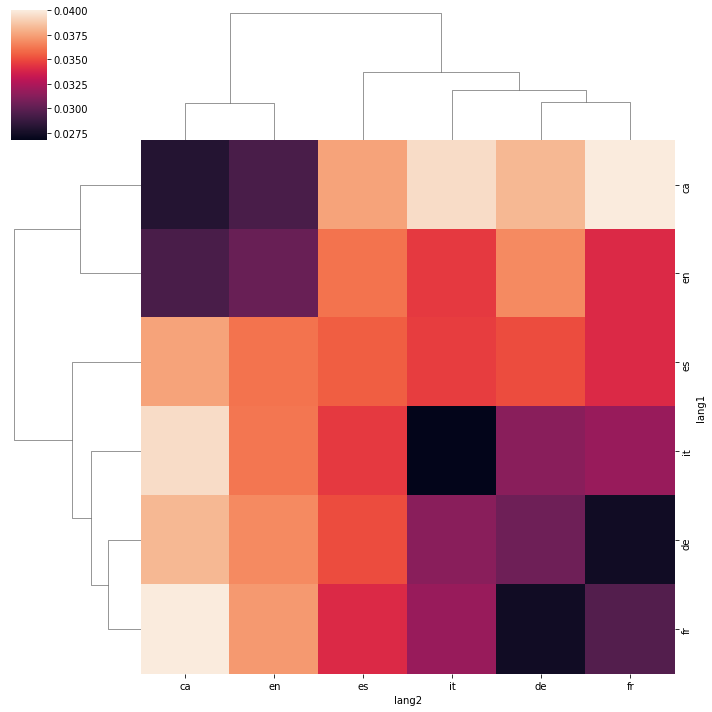

In [3]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(list_pair_distance)
sns.clustermap(df.pivot(index="lang1", columns="lang2", values="distance"))

**20. What is the hierarchical clustering ?**

$Hierarchical$ $clustering$ is a hierarchical decomposition of a given set of data objects used to group a set of objects into clusters based on their similarity, and it is an unsupervised machine learning method. It builds the hierarchy of clusters by successively merging or splitting existing clusters. According to the decomposition strategy used for hierarchical decomposition, hierarchical clustering method can be further divided into cohesive (agglomerative: bottom-up) and divisive (top-down) hierarchical clustering.

**21. Interpret the result you obtained.**

Based on the hierarchical cluster cluster diagram drawn above we can observe that French and German are the most similar, French and Italian are the next closest, followed by French and spanish, and French is the furthest from English and Catalan, but English and Catalan are also the closest to each other. However, since we only selected 10 sets of data to draw the hierarchical clustering graph, the results obtained are not very objective, because according to the division of language families, the similarity of languages under the same language family should be higher, for example, French, Italian, spanish and Catalan all belong to Romance languages, while English and German belong to the same Germanic languages, therefore there should be a higher similarity between them.